In [82]:
import cv2
import numpy as np
from PIL import Image
from ultralytics import YOLO
import matplotlib.pyplot as plt
from os import listdir

In [83]:
model = YOLO('yolov8s.pt')
classes = [2, 3, 5, 7]

In [84]:
def undistort_image(image, camera_matrix, distortion_coeffs):
    h, w = image.shape[:2]
    new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, distortion_coeffs, (w, h), 1, (w, h))
    undistorted_image = cv2.undistort(image, camera_matrix, distortion_coeffs, None, new_camera_matrix)
    return undistorted_image


In [85]:
video_path = "https://cdn.cams.is74.ru/hls/playlists/multivariant.m3u8?uuid=52062848-61de-4e39-8948-5ca14dcfcd0b&token=bearer-aa25824cdf8db4addcce63e4b6de4e44"
cap = cv2.VideoCapture(video_path)

In [86]:
img = cv2.cvtColor(cap.read()[1], cv2.COLOR_BGR2RGB)

In [87]:
camera_matrix = np.array([[2179, 0, 1433],
                          [0, 2049, 606],
                          [0, 0, 1]])
distortion_coeffs = np.array([0.48787777, -3.47110869, -0.09418035, -0.03887175, 6.42096464])

In [88]:
frame = undistort_image(img, camera_matrix, distortion_coeffs)
h, w = frame.shape[0], frame.shape[1]
frame = frame[int(h * 0.409):int(h * 0.8), int(w * 0.08):int(w * 0.9)]

In [89]:
mask = cv2.imread("result_images/mask.png")

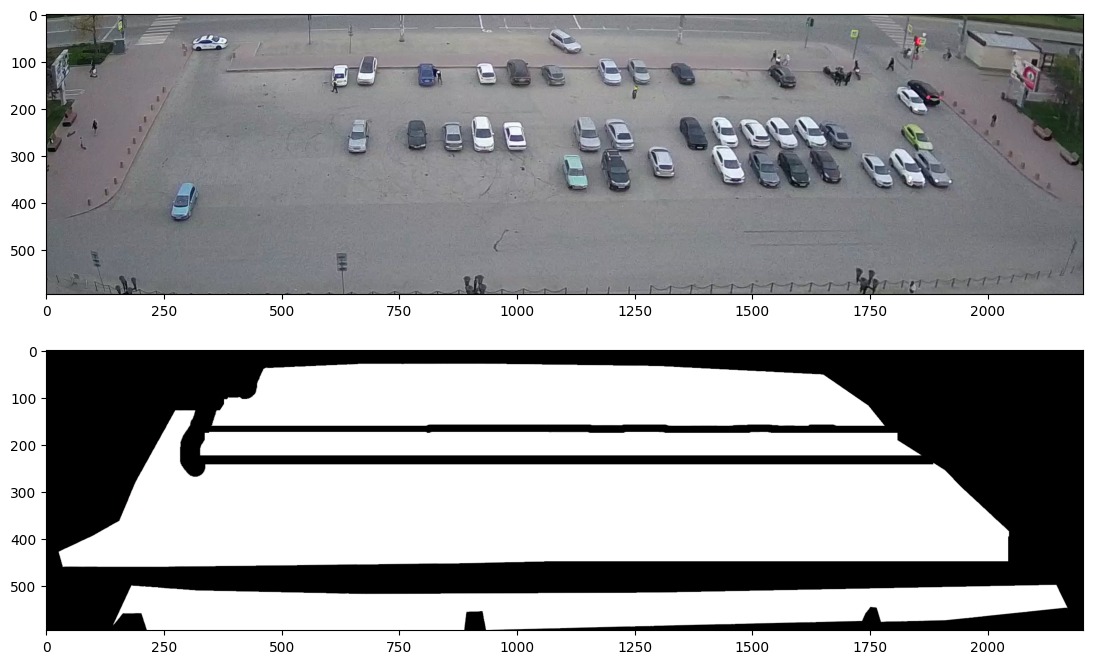

In [90]:
fig = plt.figure(figsize=(20, 8))
fig.add_subplot(211)
plt.imshow(frame)
fig.add_subplot(212)
plt.imshow(mask)
plt.show()

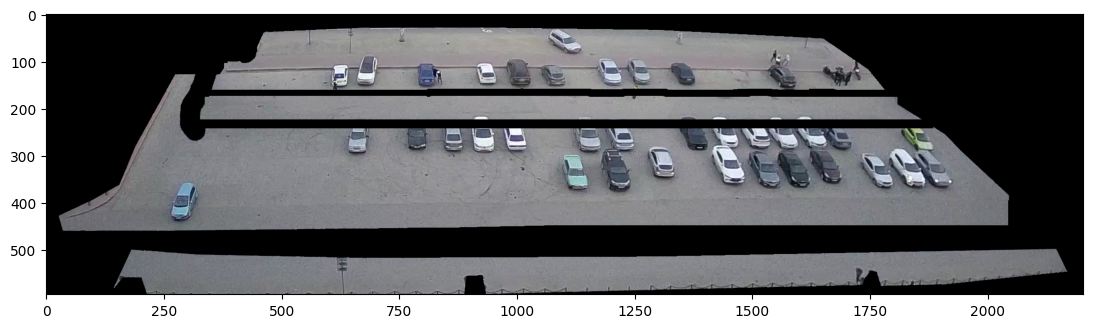

In [91]:
fig = plt.figure(figsize=(20, 8))
fig.add_subplot(211)
cut_frame = cv2.bitwise_and(frame, mask)
plt.imshow(cut_frame)
plt.show()

In [95]:
pred = model.predict(cut_frame, classes=classes, imgsz=3200, iou=0.2, conf=0.5)[0]
annotated_frame = cut_frame.copy()
w, h = annotated_frame.shape[1], annotated_frame.shape[0]

for index, cls, box in zip(range(len(pred.boxes.xywhn)), pred.boxes.cls, pred.boxes.xywhn):
    x1, y1 = np.int32([(box[0] - box[2] / 2) * w, (box[1] - box[3] / 2) * h])
    x2, y2 = np.int32([(box[0] + box[2] - box[2] / 2) * w, (box[1] + box[3] - box[3] / 2) * h])

    if ((x2 - x1) * (y2 - y1)) <= 12000:
        row = f"{int(cls)} {box[0]} {box[1]} {box[2]} {box[3]}"
        cv2.imwrite(f"dataset/train/images/{len(listdir('dataset/train/images'))}.jpg", cv2.cvtColor(cut_frame, cv2.COLOR_BGR2RGB))
        with open(f"dataset/train/labels/{len(listdir('dataset/train/labels'))}.txt", 'w') as f:
            f.write(row)
    cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), color=[255, 0, 0],
                  thickness=2)
    cv2.putText(annotated_frame, str(index), (int(box[0] * w) - 10, int(box[1] * h)),
                cv2.FONT_HERSHEY_PLAIN, 1,
                [255, 0, 0], 2)


0: 864x3200 14 cars, 1 bus, 6 trucks, 1989.8ms
Speed: 78.0ms preprocess, 1989.8ms inference, 8.0ms postprocess per image at shape (1, 3, 864, 3200)


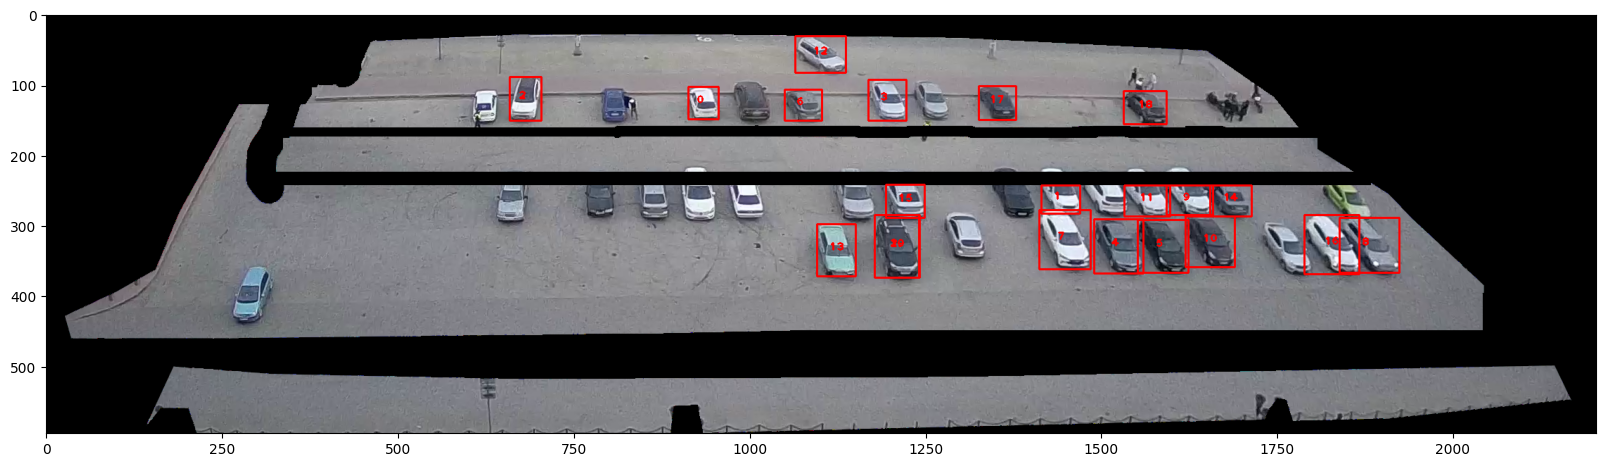

In [96]:
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot()
ax.imshow(annotated_frame)
plt.show()